<a href="https://colab.research.google.com/github/Lee-Gunju/AI-paper-code-review-for-personal-project/blob/master/Density_estimation_using_Real_NVP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.datasets import make_moons
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_probability as tfp

In [ ]:
data = make_moons(3000, noise=0.05)[0].astype('float32')

In [ ]:
data.shape

(3000, 2)

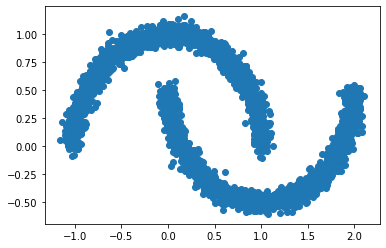

In [ ]:
plt.scatter(data[:, 0], data[:,1])

In [ ]:
norm = layers.experimental.preprocessing.Normalization()
norm.adapt(data)
normalized_data = norm(data)

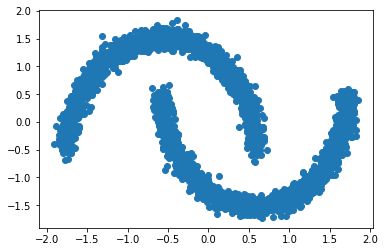

In [ ]:
plt.scatter(normalized_data[:, 0], normalized_data[:,1])

In [ ]:
# Affine coupling layer
# Creating a custom layer with keras API.

output_dim = 256
reg = 0.01

def Coupling(input_shape):
    input = keras.layers.Input(shape=input_shape)

    t_layer_1 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(input)
    t_layer_2 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_1)
    t_layer_3 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_2)
    t_layer_4 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_3)
    t_layer_5 = keras.layers.Dense(
        input_shape, activation="linear", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_4)

    s_layer_1 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(input)
    s_layer_2 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_1)
    s_layer_3 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_2)
    s_layer_4 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_3)
    s_layer_5 = keras.layers.Dense(
        input_shape, activation="tanh", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_4)

    return keras.Model(inputs=input, outputs=[s_layer_5, t_layer_5])




In [ ]:
input_shape = (32)
model = Coupling(input_shape)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32)]         0                                            
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 256)          8448        input_2[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 256)          8448        input_2[0][0]                    
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 256)          65792       dense_10[0][0]                   
______________________________________________________________________________________________

In [ ]:
num_coupling_layers = 4

masks = np.array(
            [[0, 1], [1, 0]] * (num_coupling_layers // 2), dtype="float32"
        )

In [ ]:
masks[1]

array([1., 0.], dtype=float32)

In [ ]:
normalized_data * masks[0]

<tf.Tensor: shape=(3000, 2), dtype=float32, numpy=
array([[ 0.        , -0.13905215],
       [-0.        ,  1.6258409 ],
       [ 0.        , -0.3118079 ],
       ...,
       [-0.        ,  1.3514234 ],
       [-0.        , -0.18324442],
       [ 0.        , -0.10218731]], dtype=float32)>

In [ ]:
1- masks[1]

array([0., 1.], dtype=float32)

In [ ]:
distribution = tfp.distributions.MultivariateNormalDiag(
            loc=[0.0, 0.0], scale_diag=[1.0, 1.0]
        )

In [ ]:
moo = distribution.sample(3000)

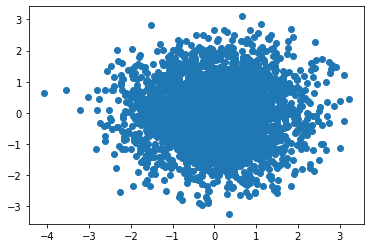

In [ ]:
plt.scatter(moo[:, 0], moo[:,1])

In [ ]:
class RealNVP(keras.Model):
    def __init__(self, num_coupling_layers):
        super(RealNVP, self).__init__()

        self.num_coupling_layers = num_coupling_layers

        # Distribution of the latent space.
        self.distribution = tfp.distributions.MultivariateNormalDiag(
            loc=[0.0, 0.0], scale_diag=[1.0, 1.0]
        )
        self.masks = np.array(
            [[0, 1], [1, 0]] * (num_coupling_layers // 2), dtype="float32"
        )
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.layers_list = [Coupling(2) for i in range(num_coupling_layers)]

    @property
    def metrics(self):
        """List of the model's metrics.
        We make sure the loss tracker is listed as part of `model.metrics`
        so that `fit()` and `evaluate()` are able to `reset()` the loss tracker
        at the start of each epoch and at the start of an `evaluate()` call.
        """
        return [self.loss_tracker]

    def call(self, x, training=True):
        log_det_inv = 0
        direction = 1
        if training:
            direction = -1
        for i in range(self.num_coupling_layers)[::direction]:
            x_masked = x * self.masks[i]
            reversed_mask = 1 - self.masks[i]
            s, t = self.layers_list[i](x_masked)
            s *= reversed_mask
            t *= reversed_mask
            gate = (direction - 1) / 2
            x = (
                reversed_mask
                * (x * tf.exp(direction * s) + direction * t * tf.exp(gate * s))
                + x_masked
            )
            log_det_inv += gate * tf.reduce_sum(s, [1])

        return x, log_det_inv


    # Log likelihood of the normal distribution plus the log determinant of the jacobian.
    
    def log_loss(self, x):
      y, log_det = self(x)
      log_likelihood = self.distribution.log_prob(y) + log_det
      return -tf.reduce_mean(log_likelihood)

    def train_step(self, data):
      with tf.GradientTape() as tape:

        loss = self.log_loss(data)

      g = tape.gradient(loss, self.trainable_variables)
      self.optimizer.apply_gradients(zip(g, self.trainable_variables))
      self.loss_tracker.update_state(loss)

      return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
      loss = self.log_loss(data)
      self.loss_tracker.update_state(loss)

      return {"loss": self.loss_tracker.result()}


In [ ]:
model = RealNVP(num_coupling_layers=6)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001))

history = model.fit(normalized_data, batch_size = 256, epochs = 300, verbose=2, validation_split=0.2)


Epoch 1/300
10/10 - 7s - loss: 2.7016 - val_loss: 2.6567
Epoch 2/300
10/10 - 0s - loss: 2.6075 - val_loss: 2.6092
Epoch 3/300
10/10 - 0s - loss: 2.5434 - val_loss: 2.5438
Epoch 4/300
10/10 - 0s - loss: 2.4946 - val_loss: 2.5068
Epoch 5/300
10/10 - 0s - loss: 2.4625 - val_loss: 2.4556
Epoch 6/300
10/10 - 0s - loss: 2.4207 - val_loss: 2.4201
Epoch 7/300
10/10 - 0s - loss: 2.3851 - val_loss: 2.3940
Epoch 8/300
10/10 - 0s - loss: 2.3527 - val_loss: 2.3595
Epoch 9/300
10/10 - 0s - loss: 2.3264 - val_loss: 2.3290
Epoch 10/300
10/10 - 0s - loss: 2.2896 - val_loss: 2.3045
Epoch 11/300
10/10 - 0s - loss: 2.2756 - val_loss: 2.2918
Epoch 12/300
10/10 - 0s - loss: 2.2486 - val_loss: 2.2610
Epoch 13/300
10/10 - 0s - loss: 2.2222 - val_loss: 2.2418
Epoch 14/300
10/10 - 0s - loss: 2.1954 - val_loss: 2.2294
Epoch 15/300
10/10 - 0s - loss: 2.1837 - val_loss: 2.2259
Epoch 16/300
10/10 - 0s - loss: 2.1633 - val_loss: 2.1765
Epoch 17/300
10/10 - 0s - loss: 2.1299 - val_loss: 2.1627
Epoch 18/300
10/10 - 0s

(-2.0, 2.0)

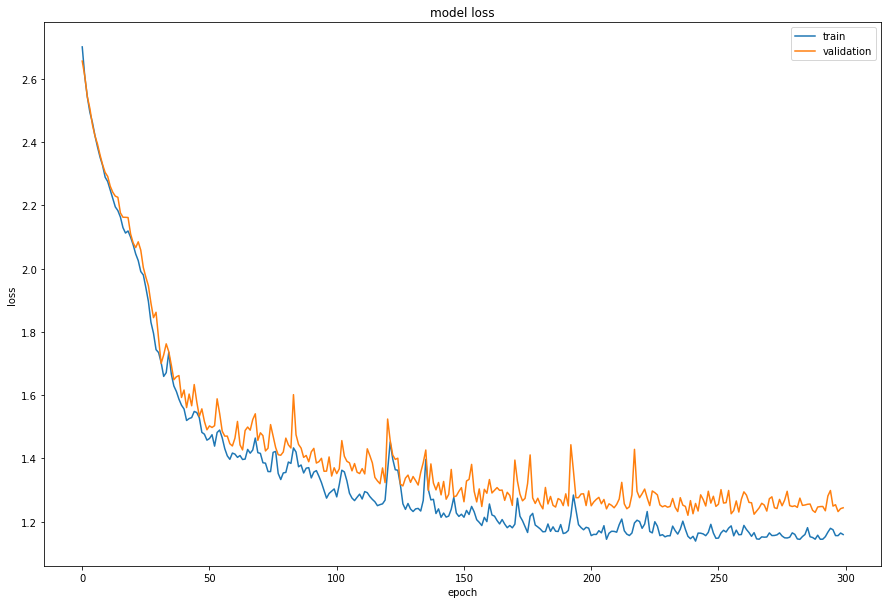

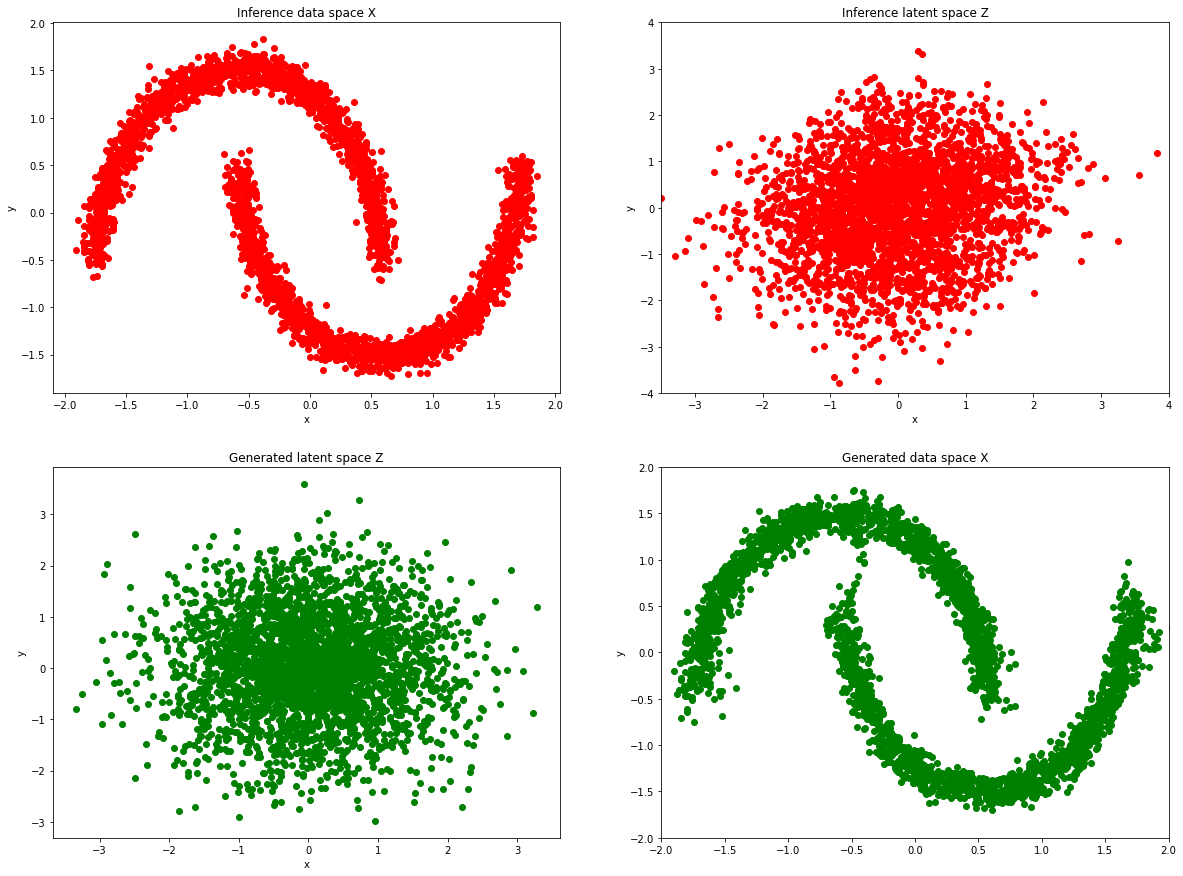

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'validation'], loc = 'upper right')
plt.ylabel('loss')
plt.xlabel('epoch')

# From data to latent space.
z, _ = model(normalized_data)

# From latent space to data.
samples = model.distribution.sample(3000)
x, _ = model.predict(samples)

f, axes = plt.subplots(2, 2)
f.set_size_inches(20, 15)


axes[0, 0].scatter(normalized_data[:, 0], normalized_data[:, 1], color="r")
axes[0, 0].set(title="Inference data space X", xlabel="x", ylabel="y")
axes[0, 1].scatter(z[:, 0], z[:, 1], color="r")
axes[0, 1].set(title="Inference latent space Z", xlabel="x", ylabel="y")
axes[0, 1].set_xlim([-3.5, 4])
axes[0, 1].set_ylim([-4, 4])
axes[1, 0].scatter(samples[:, 0], samples[:, 1], color="g")
axes[1, 0].set(title="Generated latent space Z", xlabel="x", ylabel="y")
axes[1, 1].scatter(x[:, 0], x[:, 1], color="g")
axes[1, 1].set(title="Generated data space X", label="x", ylabel="y")
axes[1, 1].set_xlim([-2, 2])
axes[1, 1].set_ylim([-2, 2])